In [2]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, printDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleRegular, emitParticlesRegular, emitParticlesSDF
from diffSPH.v2.math import volumeToSupport
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.sphOps import sphOperationFluidState
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.plotting import scatterPlotFluid, scatterPlotFluidSymmetric, plotImplicitSDF
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorField, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco
from diffSPH.v2.modules.surfaceDetection import computeSurfaceDistance, getStableSurfaceNormal
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

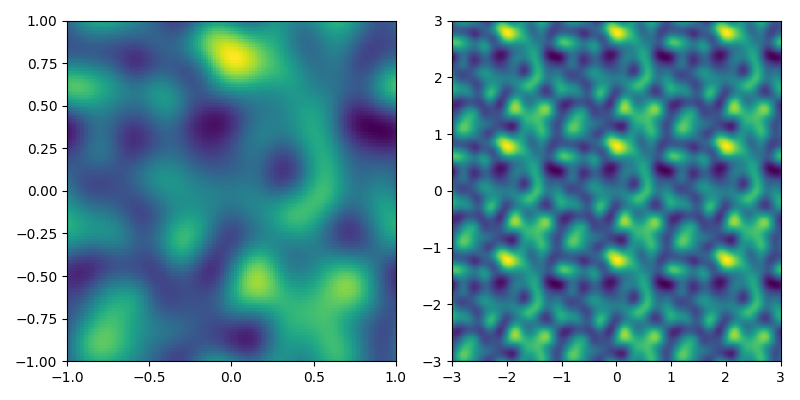

In [3]:
from diffSPH.v2.plotting import *
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from diffSPH.v2.noise import generateNoise

*grid, noiseSimplex = generateNoise(n = 128, baseFrequency= 3, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=True, kind = 'simplex')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx, yy = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx, yy, noiseSimplex.detach().cpu().numpy(), cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx + xoffset * 2, yy + yoffset * 2, noiseSimplex.detach().cpu().numpy(), cmap = 'viridis')
fig.tight_layout()

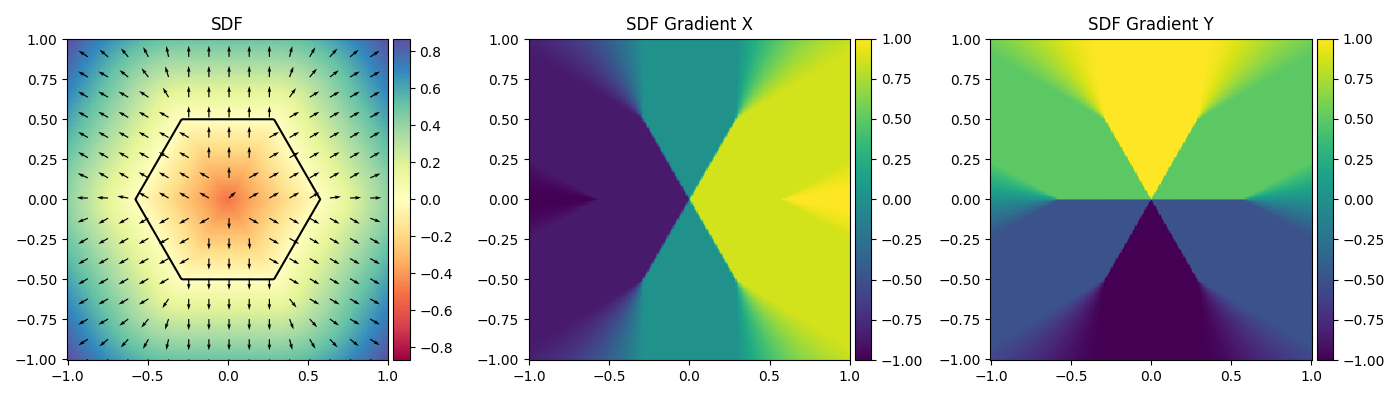

In [4]:


ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_a
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [5]:
config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': 64
    },
    'kernel':{
        'name': 'Wendland2',
        'targetNeighbors': 14
    },
    "neighborhood":{
        "scheme": "compact"
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

{'domain': {'minExtent': tensor([-1., -1.]),
  'maxExtent': tensor([1., 1.]),
  'dim': 2,
  'periodic': True,
  'periodicity': tensor([True, True])},
 'particle': {'nx': 64,
  'dx': tensor(0.0312),
  'defaultVolume': tensor(0.0010),
  'defaultSupport': 0.06596887883819925,
  'volume': tensor(0.0010),
  'support': 0.06596887883819925},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': 14,
  'function': <diffSPH.kernels.KernelWrapper at 0x7fee9c0b6b90>},
 'neighborhood': {'scheme': 'compact'},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'compute': {'device': 'cpu', 'precision': 'float32', 'dtype': torch.float32},
 'simulation': {'correctArea': False, 'supportScheme': 'symmetric'},
 'fluid': {'rho0': 1000, 'mu': 0.1, 'cs': 10},
 'diffusion': {'delta': 0.1,
  'densityScheme': 'deltaSPH',
  'velocityScheme': 'deltaSPH',
  'nu': 0.02,
  'alpha': 1.0,
  'beta': 0.0,
  'pi-switch': False,
  'artificial-constant': 0.02

In [6]:
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import filterParticlesWithSDF

particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])


# areasA = particlesA.new_ones(particlesA.shape[0]) * volumeA
# onesA = particlesA.new_ones(particlesA.shape[0])
# supportsA = particlesA.new_ones(particlesA.shape[0]) * h

factor = 1
# particlesB, volumeB = sampleRegular(dx / factor, dim, minExtent, domainMax, targetNeighbors, True, k)
# hB = volumeToSupport(volumeB, targetNeighbors, dim)
# areasB = particlesB.new_ones(particlesB.shape[0]) * volumeA
# onesB = particlesB.new_ones(particlesB.shape[0])
# supportsB = particlesB.new_ones(particlesB.shape[0]) * h
h = volumeToSupport(volumeA, config['kernel']['targetNeighbors'], config['domain']['dim'])

maskedA, maskA, sdfValues, sdfGradients = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), h, -1e-4)

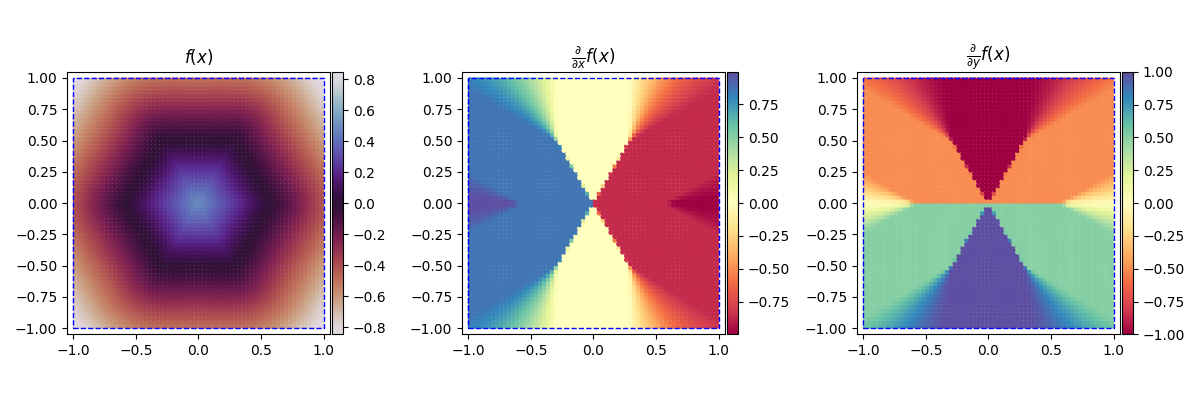

In [7]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotSymmetric(fig, axis[0,0], particlesA, sdfValues, config['domain']['minExtent'], config['domain']['maxExtent'], '$f(x)$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[0,1], particlesA, sdfGradients[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial x} f(x)$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], particlesA, sdfGradients[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial y} f(x)$', cmap = 'Spectral', s = 8)

fig.tight_layout()

torch.Size([64, 64])


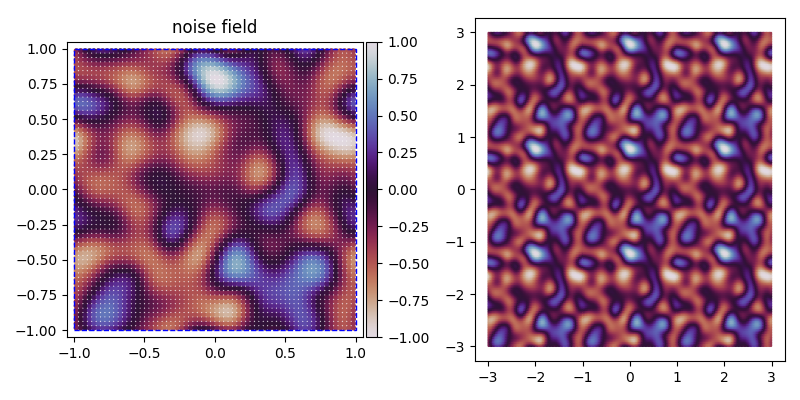

In [8]:
nx = config['particle']['nx']
*grid, noiseSimplex = generateNoise(n = nx, baseFrequency= 3, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=True, kind = 'simplex')

print(noiseSimplex.shape)
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
scatterPlotSymmetric(fig, axis[0,0], particlesA, noiseSimplex.flatten(), config['domain']['minExtent'], config['domain']['maxExtent'], 'noise field', cmap = 'twilight_r', s = 8)
for offset in [[-1,-1], [0,-1], [1,-1], [-1,0], [0,0], [1,0], [-1,1], [0,1], [1,1]]:
    axis[0,1].scatter(particlesA[:,0] + offset[0] * 2, particlesA[:,1] + offset[1] * 2, c = noiseSimplex.flatten(), cmap = 'twilight_r', s = 1)
fig.tight_layout()

In [9]:
noiseConfig = {
    'n': nx,
    'baseFrequency': 3,
    'dim': 2,
    'octaves': 1,
    'persistence': 0.5,
    'lacunarity': 2.0,
    'seed': 23467586,
    'tileable': True,
    'kind': 'simplex'
}


In [10]:
def sampleNoise(noiseConfig):
    if 'baseFrequency' not in noiseConfig:
        noiseConfig['baseFrequency'] = 3
    if 'dim' not in noiseConfig:
        noiseConfig['dim'] = 2
    if 'octaves' not in noiseConfig:
        noiseConfig['octaves'] = 1
    if 'persistence' not in noiseConfig:
        noiseConfig['persistence'] = 0.5
    if 'lacunarity' not in noiseConfig:
        noiseConfig['lacunarity'] = 2.0
    if 'seed' not in noiseConfig:
        noiseConfig['seed'] = 234675
    if 'tileable' not in noiseConfig:
        noiseConfig['tileable'] = True
    if 'kind' not in noiseConfig:
        noiseConfig['kind'] = 'simplex'
    

    *grid, noise = generateNoise(**noiseConfig)
    return grid, noise



def sampleVelocityField(noiseState):
    gradTerm = sphOperationFluidState(noiseState, (noiseState['fluidPotential'], noiseState['fluidPotential']), 'gradient', 'difference')
    velocities = torch.stack([gradTerm[:,1], -gradTerm[:,0]], dim = -1)
    divergence = sphOperationFluidState(noiseState, (noiseState['fluidVelocities'], noiseState['fluidVelocities']), 'divergence')
    return velocities, divergence

def rampDivergenceFree(positions, noise, sdf_func, offset, d0 = 0.25):
    sdf = sdf_func(positions)
#     r = sdf / d0 /2  + 0.5
    r = (sdf - offset) / d0 / 0.5 - 1
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
    ramped[r <= -1] = -1
#     ramped[r <= 0] = 0
#     ramped[r <= -1] = -1
    
    return (ramped /2 + 0.5) * (noise)


def rampOrthogonal(positions, noise, sdf_func, offset, d0 = 0.25):
    sdf = sdf_func(positions)
#     r = sdf / d0 /2  + 0.5
    r = (sdf - offset) / d0 
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
    ramped[r <= -1] = -1
#     ramped[r <= 0] = 0
#     ramped[r <= -1] = -1
    
    return (ramped) * (noise)

def filterPotentialField(sdf, noiseState, fluidConfig, kind = 'divergenceFree'):
    if kind == 'divergenceFree':
        return rampDivergenceFree(noiseState['fluidPositions'], noiseState['fluidPotential'], sdf, offset = noiseState['fluidSupports'], d0 = noiseState['fluidSupports'])
    else:
        return rampOrthogonal(noiseState['fluidPositions'], noiseState['fluidPotential'], sdf, offset = fluidConfig['particle']['dx'] / 2, d0 = noiseState['fluidSupports'])
    

def sampleNoisyParticles(noiseConfig, config, sdfs = []):
    particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
    
    noiseState = {}
    area = (4 / config['particle']['nx']**2)
    area = volumeA
    grid, noiseSimplex = sampleNoise(noiseConfig)
    noiseState['fluidPositions'] = particlesA
    noiseState['fluidAreas'] = particlesA.new_ones(particlesA.shape[0]) * area
    noiseState['fluidMasses'] = noiseState['fluidAreas'] * config['fluid']['rho0']
    noiseState['fluidSupports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
    noiseState['fluidVelocities'] = torch.zeros_like(particlesA)
    noiseState['fluidPotential'] = noiseSimplex.flatten()
    noiseState['fluidIndex'] = torch.arange(particlesA.shape[0], device = particlesA.device)

    noiseState['numParticles'] = particlesA.shape[0]

    noiseState['fluidNeighborhood'] = fluidNeighborSearch(noiseState, config)
    noiseState['fluidDensities'] = sphOperationFluidState(noiseState, None, 'density')
    _, noiseState['fluidNumNeighbors'] = countUniqueEntries(noiseState['fluidNeighborhood']['indices'][0], noiseState['fluidPositions'])

    for sdf in sdfs:
        noiseState['fluidPotential'] = filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree')
    noiseState['fluidVelocities'], noiseState['fluidDivergence'] = sampleVelocityField(noiseState)
    mask = torch.ones_like(noiseState['fluidPotential'], dtype = torch.bool)
    for sdf_func in sdfs:
        _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), h, -1e-4)
        mask = mask & maskA
    noiseState['fluidVelocities'][~mask, :] = 0


    return noiseState, mask

In [11]:
noiseState,_ = sampleNoisyParticles(noiseConfig, config)
# noiseState['fluidVelocities'], noiseState['fluidDivergence'] = sampleVelocityField(noiseState)

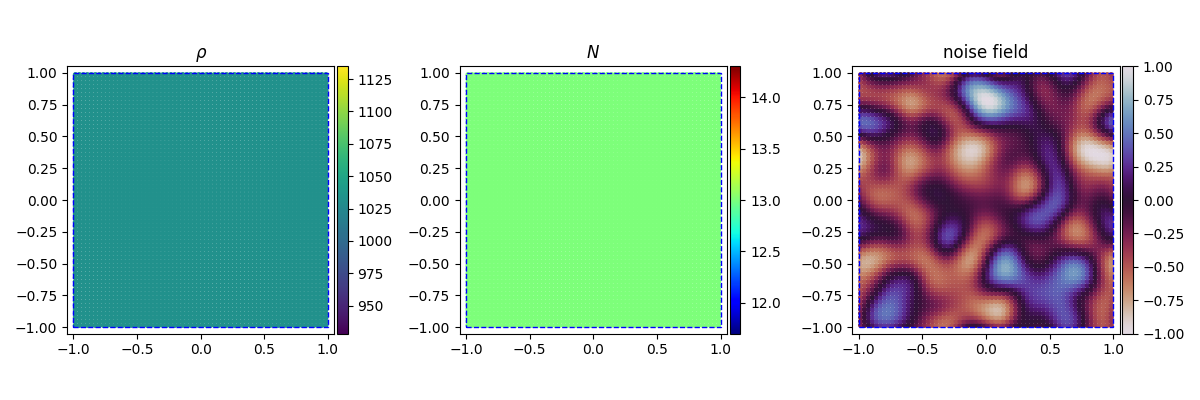

In [12]:


fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], noiseState['fluidPositions'], noiseState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], noiseState['fluidPositions'], noiseState['fluidNumNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlotSymmetric(fig, axis[0,2], noiseState['fluidPositions'], noiseSimplex.flatten(), config['domain']['minExtent'], config['domain']['maxExtent'], 'noise field', cmap = 'twilight_r', s = 8)

fig.tight_layout()

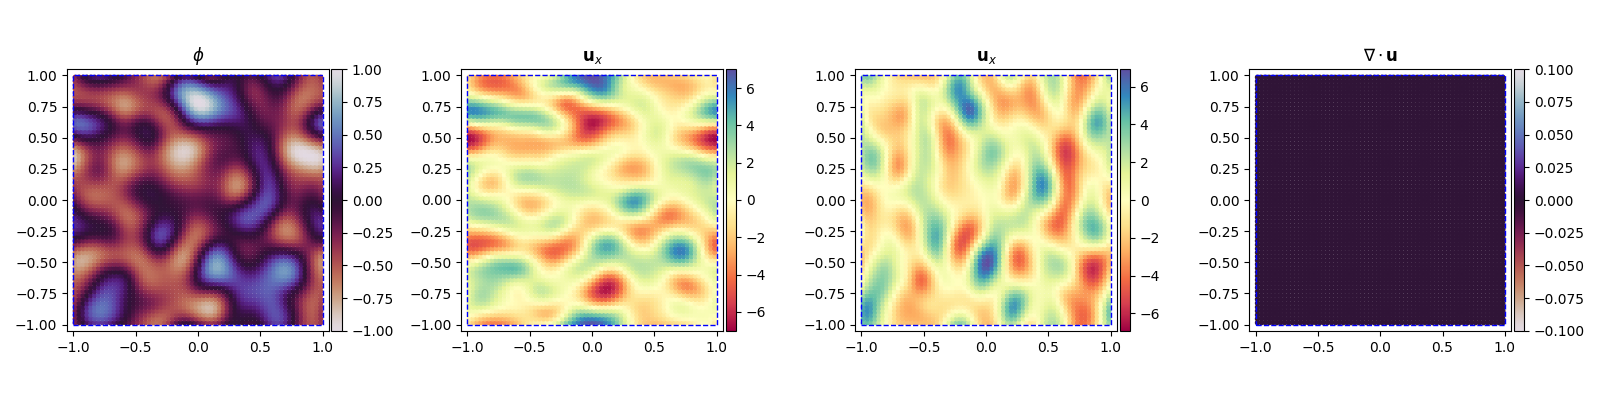

In [13]:
# gradTerm = sphOperationFluidState(noiseState, (noiseState['fluidPotential'], noiseState['fluidPotential']), 'gradient', 'difference')
# noiseState['fluidVelocities'] = torch.stack([gradTerm[:,1], -gradTerm[:,0]], dim = -1)
# noiseState['fluidDivergence'] = sphOperationFluidState(noiseState, (noiseState['fluidVelocities'], noiseState['fluidVelocities']), 'divergence')

fig, axis = plt.subplots(1, 4, figsize=(16,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], noiseState['fluidPositions'], noiseState['fluidPotential'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\phi$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[0,1], noiseState['fluidPositions'], noiseState['fluidVelocities'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], noiseState['fluidPositions'], noiseState['fluidVelocities'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[0,3], noiseState['fluidPositions'], noiseState['fluidDivergence'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\cdot\\mathbf{u}$', cmap = 'twilight_r', s = 8)

fig.tight_layout()

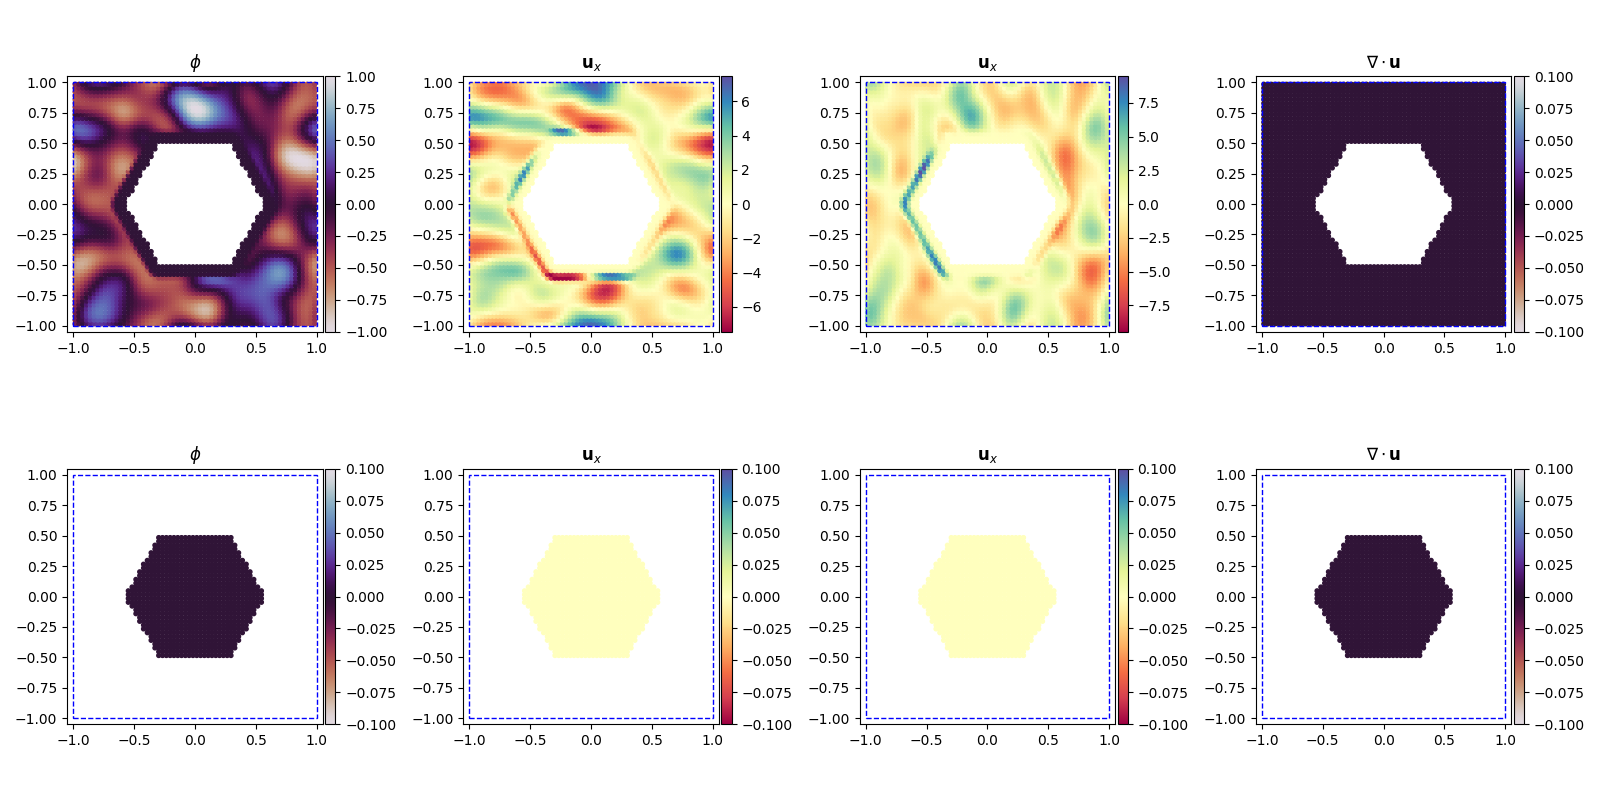

In [14]:
# noiseState['fluidPotentialFiltered'] = filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree')
# # noiseState['fluidPotentialFiltered'] = filterPotential(noiseState['fluidPositions'], noiseState['fluidPotential'], sdf, offset = config['particle']['dx']/2, d0 = noiseState['fluidSupports'])

# gradTerm = sphOperationFluidState(noiseState, (noiseState['fluidPotentialFiltered'], noiseState['fluidPotentialFiltered']), 'gradient', 'difference')
# noiseState['fluidVelocities'] = torch.stack([gradTerm[:,1], -gradTerm[:,0]], dim = -1)

# # noiseState['fluidVelocities'][~maskA,:] = 0

# noiseState['fluidDivergence'] = sphOperationFluidState(noiseState, (noiseState['fluidVelocities'], noiseState['fluidVelocities']), 'divergence')
noiseState, mask = sampleNoisyParticles(noiseConfig, config, sdfs = [sdf])
# sdfs = [sdf]

# mask = torch.ones_like(noiseState['fluidPotential'], dtype = torch.bool)
# for sdf_func in sdfs:
#     _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), h, -1e-4)
#     mask = mask & maskA

# maskA = mask

fig, axis = plt.subplots(2, 4, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], noiseState['fluidPositions'][maskA,:], noiseState['fluidPotential'][maskA], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\phi$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[0,1], noiseState['fluidPositions'][maskA,:], noiseState['fluidVelocities'][maskA,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], noiseState['fluidPositions'][maskA,:], noiseState['fluidVelocities'][maskA,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[0,3], noiseState['fluidPositions'][maskA,:], noiseState['fluidDivergence'][maskA], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\cdot\\mathbf{u}$', cmap = 'twilight_r', s = 8)

scatterPlot(fig, axis[1,0], noiseState['fluidPositions'][~maskA,:], noiseState['fluidPotential'][~maskA], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\phi$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[1,1], noiseState['fluidPositions'][~maskA,:], noiseState['fluidVelocities'][~maskA,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,2], noiseState['fluidPositions'][~maskA,:], noiseState['fluidVelocities'][~maskA,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,3], noiseState['fluidPositions'][~maskA,:], noiseState['fluidDivergence'][~maskA], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\cdot\\mathbf{u}$', cmap = 'twilight_r', s = 8)


fig.tight_layout()

In [15]:
# particles = torch.cat([coarseParticles, fineParticles], dim = 0)
import copy

# perennialState = {}

# area = (4 / config['particle']['nx']**2)
# perennialState['fluidPositions'] = particles
# perennialState['fluidAreas'] = particles.new_ones(particles.shape[0]) * 2 * area
# perennialState['fluidMasses'] = perennialState['fluidAreas'] * config['fluid']['rho0']
# perennialState['fluidSupports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
# perennialState['fluidVelocities'] = torch.zeros_like(particles)

# perennialState['numParticles'] = particles.shape[0]

# perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
# perennialState['fluidDensities'] = sphOperationFluidState(perennialState, None, 'density')
# _, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])

noiseState, mask = sampleNoisyParticles(noiseConfig, config, sdfs = [sdf])
initialState = copy.deepcopy(noiseState)
config['fluid']['mu'] = 0.01
config['integration']['scheme'] = 'semiImplicitEuler'

In [26]:
# from diffSPH.v2.modules.pressureEOS import computeEOS
# from diffSPH.v2.modules.pressureForce import computePressureAccel
# from diffSPH.v2.modules.viscosity import computeViscosityMonaghan


# def simulationStep(simulationState, config):
#     simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
#     simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')

#     simulationState['fluidPressures'] = computeEOS(simulationState, config)
#     # simulationState['fluidPressures'] = 1.5 * (simulationState['fluidDensities'] - config['fluid']['rho0'])
#     simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config) #sphOperationFluidState(simulationState, (simulationState['fluidPressures'], simulationState['fluidPressures']), operation = 'gradient', gradientMode='symmetric') / simulationState['fluidDensities'].view(-1,1) #computePressureForce(simulationState, config)
#     simulationState['fluidViscosityAccel'] = computeViscosityMonaghan(simulationState, config)

#     dudt = simulationState['fluidPressureAccel'] + simulationState['fluidViscosityAccel']# * simulationState['fluidDensities'].view(-1,1)

#     return dudt

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.autonotebook import tqdm
import copy

dudt = None

import matplotlib.pyplot as plt
import matplotlib.colors as colors

norm = colors.Normalize(vmin=0, vmax=2048)
cmap = plt.cm.get_cmap('viridis')

perennialState = copy.deepcopy(initialState)
perennialState['fluidVelocities'] = perennialState['fluidVelocities'] / torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1))
perennialState['fluidMasses'] = perennialState['fluidMasses'] * 2
perennialState['fluidAreas'] = perennialState['fluidAreas'] * 2
simulationStates = []
# perennialState, dudt = integrate(simulationStep, perennialState, config, previousStep= dudt)

In [17]:
# torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1))

tensor(0.9946)

In [28]:
# from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

# fig, axis = plt.subplot_mosaic('''AABCC
#                                AADCC''', figsize=(12,4), sharex = False, sharey = False)

# # fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

# visualizationState = prepVisualizationState(perennialState, config)
# plotStateDensity = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidIndex'], cbar = True, cmap = 'twilight_r', scaling = 'lin', midPoint = 0, gridVisualization= False)
# axis['A'].set_title('$\\rho$')
# plotStateA = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.x', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['B'].set_title('$\\mathbf{u}_x$')
# plotStateB = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.y', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['D'].set_title('$\\mathbf{u}_y$')
# plotStateVelocityNorm = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidVelocities'], mapping = 'L2', cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True)
# axis['C'].set_title('$|\\mathbf{u}|$')
# fig.tight_layout()

In [29]:
# config['integration']['scheme'] = 'RK4'
# config['deltaSPH'] = {'alpha': 0.02, 'delta': 0.1}

In [30]:
# import os
# import datetime

# timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
# outFolder = './output/' + timestamp + '/'
# os.makedirs(outFolder, exist_ok = True)



In [33]:
# for i in tqdm(range(64)):
#     perennialState, dudt = integrate(simulationStep, perennialState, config, previousStep= dudt)

#     # simulationStates.append(copy.deepcopy(perennialState))


#     if i % 1 == 16 and i > 0:
#         visualizationState = prepVisualizationState(perennialState, config)
#         updatePlot(plotStateDensity, visualizationState, perennialState['fluidIndex'])
#         updatePlot(plotStateA, visualizationState, perennialState['fluidVelocities'])
#         updatePlot(plotStateB, visualizationState, perennialState['fluidVelocities'])
#         updatePlot(plotStateVelocityNorm, visualizationState, perennialState['fluidVelocities'])
        
#         fig.canvas.draw()
#         fig.canvas.flush_events()

#         # fig.savefig(outFolder + 'frame_{:04d}.png'.format(i), dpi = 300)
#         # break
#     # break

In [34]:
# import subprocess
# import shlex

# command = '/usr/bin/ffmpeg -y -r 60 -i ' + outFolder + 'frame_%04d.png -c:v libx264 -vf "fps=60,format=yuv420p" ' + outFolder + 'output.mp4'
# subprocess.run(shlex.split(command))


In [35]:

# import shlex

# commandA = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale=720:-1:flags=lanczos,palettegen" {outFolder}palette.png'
# commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=10,scale=320:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp}.gif'

# subprocess.run(shlex.split(commandA))
# subprocess.run(shlex.split(commandB))

In [36]:
# commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=10,scale=720:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp}.gif'

# subprocess.run(shlex.split(commandB))

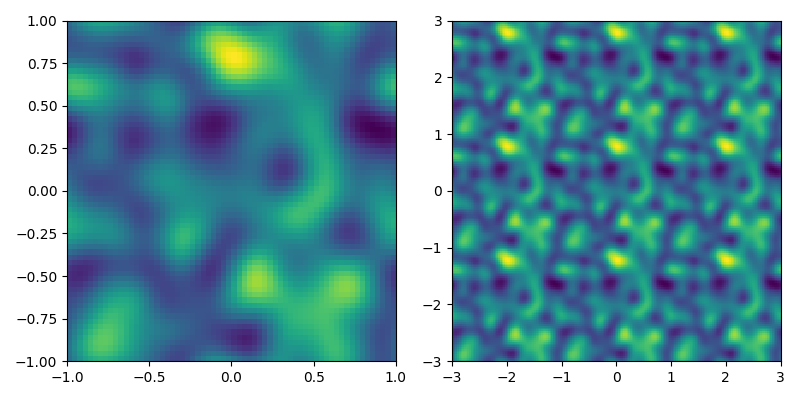

In [49]:
from diffSPH.v2.plotting import *
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from diffSPH.v2.noise import generateNoise

*grid, noiseSimplex = generateNoise(n = 64, baseFrequency= 3, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=True, kind = 'simplex')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx, yy = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx, yy, noiseSimplex.detach().cpu().numpy(), cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx + xoffset * 2, yy + yoffset * 2, noiseSimplex.detach().cpu().numpy(), cmap = 'viridis')
fig.tight_layout()

In [98]:
print(torch.sum(mask))

tensor(3208)


In [115]:
perennialState,_ = sampleNoisyParticles(noiseConfig, config)

perennialState['fluidSupports'] = torch.ones_like(perennialState['fluidMasses']) * config['particle']['dx'] * 2
config['particle']['support'] = config['particle']['dx'] * 2
config['particle']['defaultSupport'] = config['particle']['dx'] * 2

display(config['particle'])

for k in perennialState.keys():
    if isinstance(perennialState[k], torch.Tensor):
        perennialState[k] = perennialState[k][~mask]
        # print(k, perennialState[k].shape)

perennialState['numParticles'] = perennialState['fluidPositions'].shape[0]

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)

{'nx': 64,
 'dx': tensor(0.0312),
 'defaultVolume': tensor(0.0010),
 'defaultSupport': tensor(0.0625),
 'volume': tensor(0.0010),
 'support': tensor(0.0625)}

In [116]:
perennialState['fluidDivergence'].shape

torch.Size([888])

In [117]:
perennialState['fluidDensities'] = perennialState['fluidPotential'] * 100 + 1000

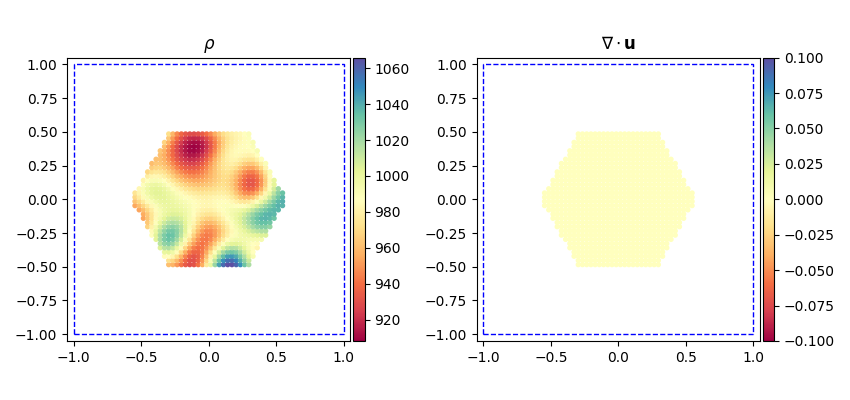

In [118]:
fig, axis = plt.subplots(1, 2, figsize=(8.5,4), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], perennialState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], perennialState['fluidDivergence'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\cdot\\mathbf{u}$', cmap = 'Spectral', s = 8)
fig.tight_layout()

In [119]:
# fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

# scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], perennialState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)

# scatterPlotSymmetric(fig, axis[0,1], perennialState['fluidPositions'], momentum, config['domain']['minExtent'], config['domain']['maxExtent'], '$-\\rho\\nabla\\cdot\\mathbf{u}$', cmap = 'Spectral', s = 8)

# fig.tight_layout()
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices

# perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)


In [120]:
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationFluidState
def computeMomentumEquation(simulationState, config):
        return -simulationState['fluidDensities'] * sphOperationFluidState(simulationState, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), operation = 'divergence', gradientMode='difference')


perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)
gradRho = sphOperationFluidState(perennialState, (perennialState['fluidDensities'], perennialState['fluidDensities']), operation = 'gradient', gradientMode='difference')
perennialState['fluidGradRho^L'] = renormalizedDensityGradient(perennialState, config)
densityDiffusion = computeDensityDeltaTerm(perennialState, config)
momentum = computeMomentumEquation(perennialState, config)


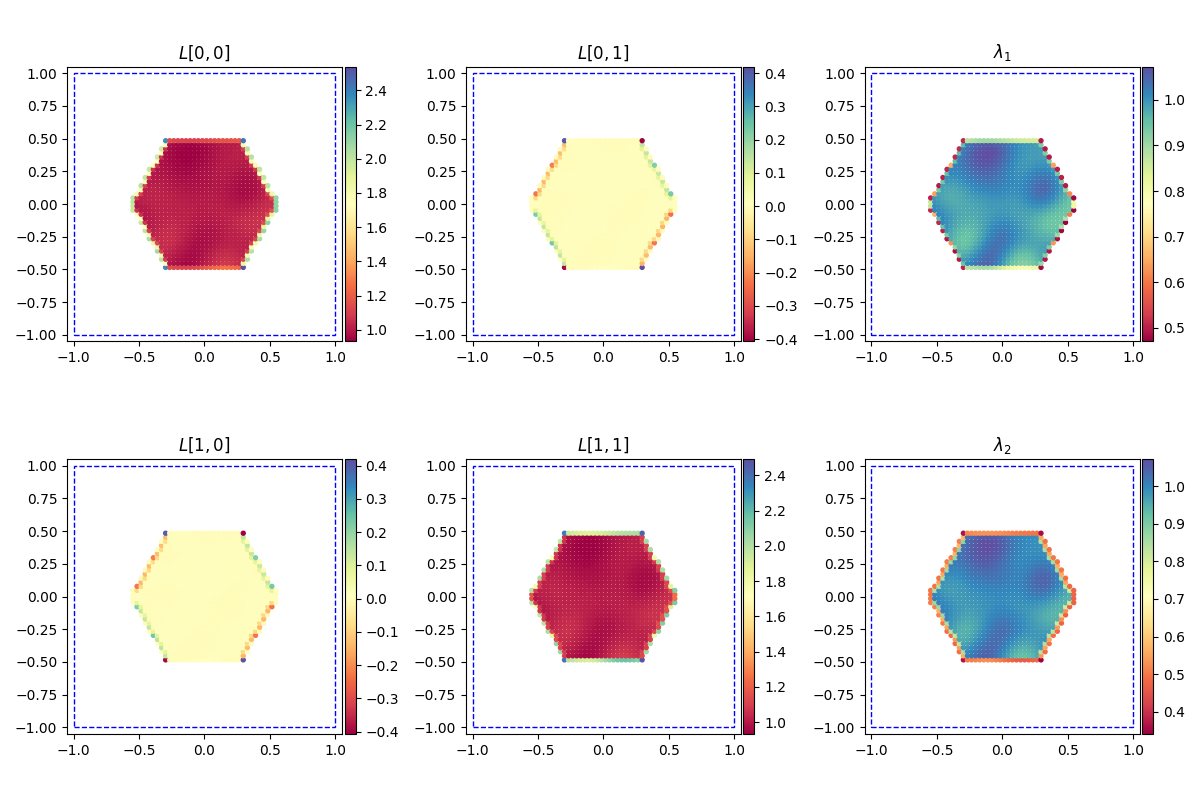

In [121]:
fig, axis = plt.subplots(2, 3, figsize=(12,8), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], perennialState['fluidL'][:,0,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$L[0,0]$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], perennialState['fluidL'][:,0,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$L[0,1]$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,0], perennialState['fluidPositions'], perennialState['fluidL'][:,1,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$L[1,0]$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,1], perennialState['fluidPositions'], perennialState['fluidL'][:,1,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$L[1,1]$', cmap = 'Spectral', s = 8)

scatterPlot(fig, axis[0,2], perennialState['fluidPositions'], perennialState['fluidL.EVs'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\lambda_1$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], perennialState['fluidPositions'], perennialState['fluidL.EVs'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\lambda_2$', cmap = 'Spectral', s = 8)

fig.tight_layout()

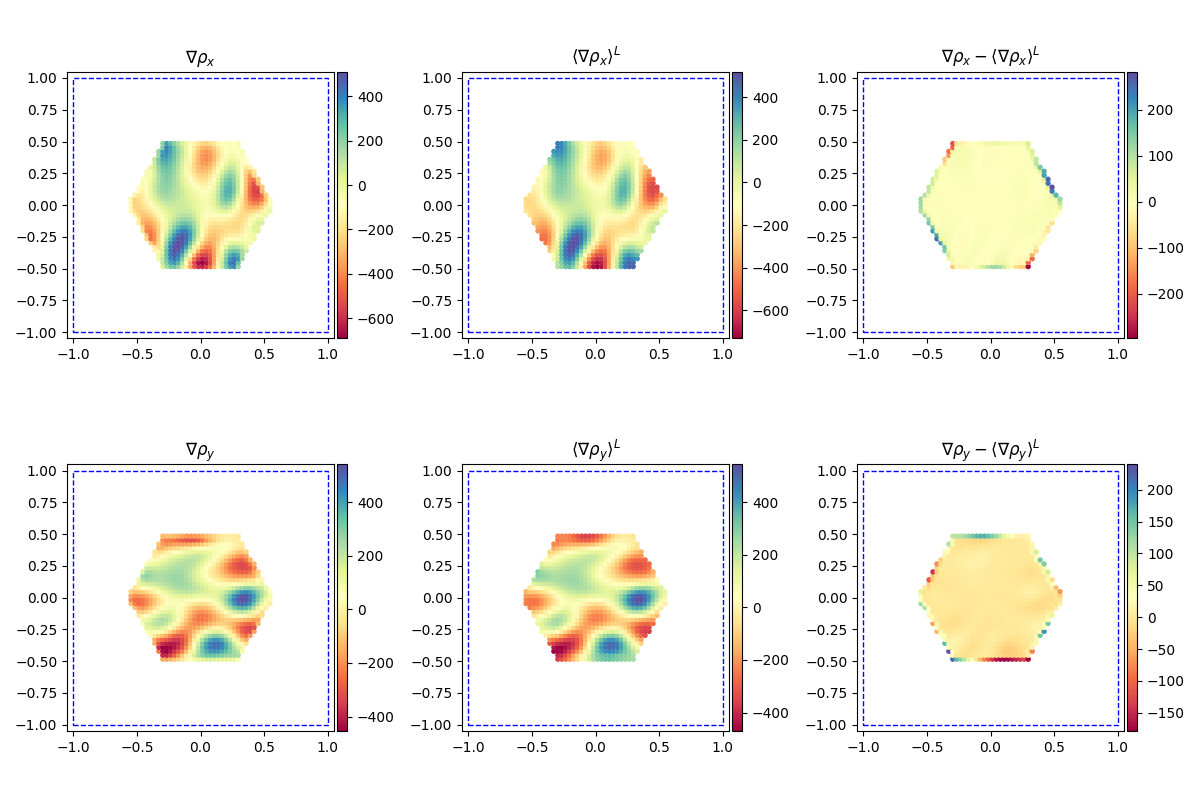

In [122]:
fig, axis = plt.subplots(2, 3, figsize=(12,8), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], gradRho[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\rho_x$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,0], perennialState['fluidPositions'], gradRho[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\rho_y$', cmap = 'Spectral', s = 8)

scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], perennialState['fluidGradRho^L'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\langle\\nabla\\rho_x\\rangle^L$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,1], perennialState['fluidPositions'], perennialState['fluidGradRho^L'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\langle\\nabla\\rho_y\\rangle^L$', cmap = 'Spectral', s = 8)

scatterPlot(fig, axis[0,2], perennialState['fluidPositions'], gradRho[:,0] - perennialState['fluidGradRho^L'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\rho_x - \\langle\\nabla\\rho_x\\rangle^L$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], perennialState['fluidPositions'], gradRho[:,1] - perennialState['fluidGradRho^L'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\rho_y - \\langle\\nabla\\rho_y\\rangle^L$', cmap = 'Spectral', s = 8)

fig.tight_layout()

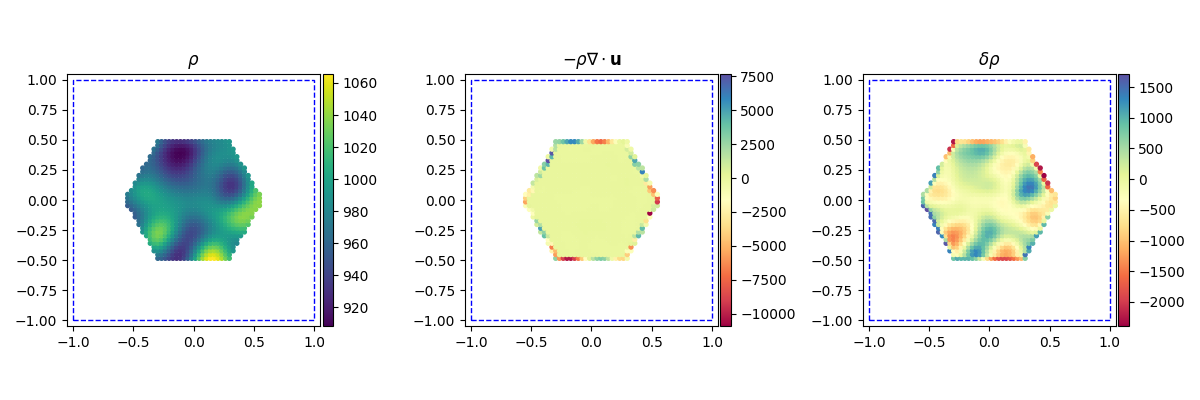

In [123]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], perennialState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], momentum, config['domain']['minExtent'], config['domain']['maxExtent'], '$-\\rho\\nabla\\cdot\mathbf{u}$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[0,2], perennialState['fluidPositions'], densityDiffusion, config['domain']['minExtent'], config['domain']['maxExtent'], '$\\delta\\rho$', cmap = 'Spectral', s = 8)

fig.tight_layout()

In [124]:
config['diffusion']['densityScheme']

'deltaSPH'

In [125]:
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices

# perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)
# perennialState['fluidGradRho^L'] = renormalizedDensityGradient(perennialState, config)

initialDensity = perennialState['fluidDensities'].clone()

In [126]:
def computeDensityDeltaTerm(fluidState, config):
    (i, j) = fluidState['fluidNeighborhood']['indices']
    scheme = 'deltaSPH'

    rij = fluidState['fluidNeighborhood']['distances'] * fluidState['fluidNeighborhood']['supports']
    if scheme == 'deltaSPH':
        grad_ij = fluidState['fluidGradRho^L'][i] + fluidState['fluidGradRho^L'][j]
        rho_ij = 2 * (fluidState['fluidDensities'][j] - fluidState['fluidDensities'][i]) / (rij + 1e-6 * fluidState['fluidNeighborhood']['supports'])
        psi_ij = -rho_ij.view(-1,1) * fluidState['fluidNeighborhood']['vectors'] - grad_ij
    elif scheme == 'denormalized':
        grad_ij = fluidState['fluidGradRho'][i] + fluidState['fluidGradRho'][j]
        rho_ij = 2 * (fluidState['fluidDensities'][j] - fluidState['fluidDensities'][i]) / (rij + 1e-6 * fluidState['fluidSupports'])
        psi_ij = -rho_ij.view(-1,1) * fluidState['fluidNeighborhood']['vectors'] - grad_ij
    elif scheme == 'densityOnly':
        rho_ij = 2 * (fluidState['fluidDensities'][j] - fluidState['fluidDensities'][i]) / (rij + 1e-6 * fluidState['fluidSupports'])
        psi_ij = -rho_ij.view(-1,1) * fluidState['fluidNeighborhood']['vectors']

    return 0.1 * fluidState['fluidSupports'] * config['fluid']['cs'] * sphOperationFluidState(fluidState, psi_ij, operation = 'divergence', gradientMode='difference')


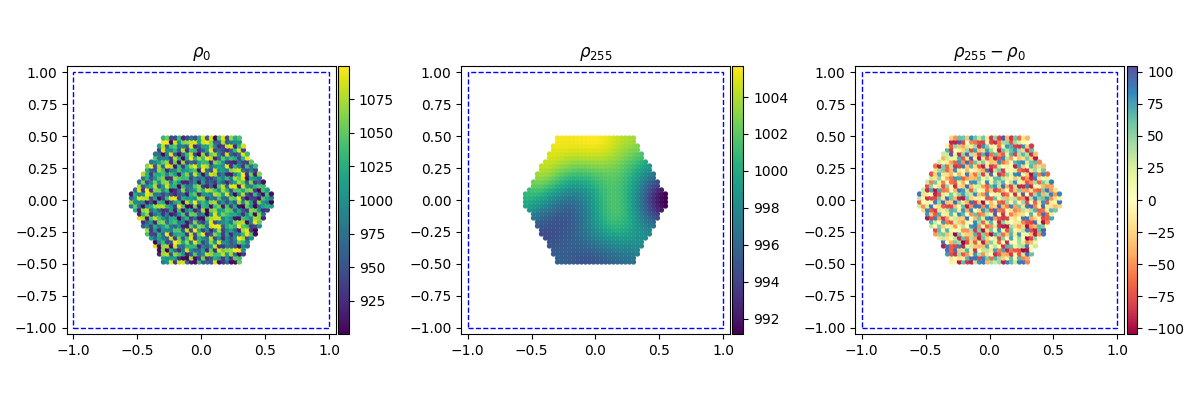

In [127]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
initialDensity = torch.rand(perennialState['fluidDensities'].shape, device = perennialState['fluidDensities'].device) * 200 + 900

scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], initialDensity, config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho_0$', cmap = 'viridis', s = 8)

perennialState['fluidDensities'] = initialDensity.clone()


    
for i in range(256):
    perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)
    perennialState['fluidGradRho^L'] = renormalizedDensityGradient(perennialState, config)
    perennialState['fluidGradRho'] = sphOperationFluidState(perennialState, (perennialState['fluidDensities'], perennialState['fluidDensities']), operation = 'gradient', gradientMode='difference')
    densityDiffusion = computeDensityDeltaTerm(perennialState, config)
    # momentum = computeMomentumEquation(perennialState, config)
    perennialState['fluidDensities'] += densityDiffusion * 0.0005
scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], perennialState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], f'$\\rho_{{{i}}}$', cmap = 'viridis', s = 8)


scatterPlotSymmetric(fig, axis[0,2], perennialState['fluidPositions'], perennialState['fluidDensities'] - initialDensity, config['domain']['minExtent'], config['domain']['maxExtent'], f'$\\rho_{{{i}}} - \\rho_0$', cmap = 'Spectral', s = 8)
fig.tight_layout()